<a href="https://colab.research.google.com/github/UmaGhildiyal/Deep_Neural_Networks_YT/blob/main/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'telco-customer-churn:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F13996%2F18858%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240614%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240614T124014Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5bd79f329def8ab1dc32948bd1ca25145f0ffad1aa3c1909897fbb8928a37b2acbfb719e70bc4c7fa76b3cc4d35f530fda36754573d76301f6a406348d935d69f2f3d2ace2f76ac14da4992259e2bb1fd1f218d3fcaf2aa7efb797d727c93994b81ddb970073e917a284b59f67826e741737c3b5af1fbe922468088f5a0851235b9286aca4558d02a88bbd7efa76fad124e136f3e79d87b830d48b35a576df20a0c826d9064665f823636a0fac68b635d19186683870aff5dab278f9bf937f816f2e009a32d6d6e592bb799e2b191dcce27dc4ed679f8dd85f180b9d7763d8d87d614a2b7922cf8bb328101d78e3138f1636651f2c52864096808782dcb97d52'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 175758 bytes downloaded
Downloaded and uncompressed: telco-customer-churn
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Get Data

In [3]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


CustomerID is useless here in machine learning

In [4]:
df.drop('customerID', axis = 'columns', inplace=True)

In [5]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TotalCharges is object

In [6]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [8]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

there are some null/empty values

In [9]:
pd.to_numeric(df.TotalCharges, errors='coerce')

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [11]:
print(df.shape)
# original no. of rows

print(df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()].shape)
# 11 rows have null values in TotalCharges

df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()]

(7043, 20)
(11, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


dropping all 11 rows

In [12]:
df1 = df[df.TotalCharges!= ' ']
df1.shape

(7032, 20)

In [13]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [14]:
df1 = df1.copy()
df1['TotalCharges'] = pd.to_numeric(df1['TotalCharges'])
df1.TotalCharges.dtypes

dtype('float64')

# Data Visualization

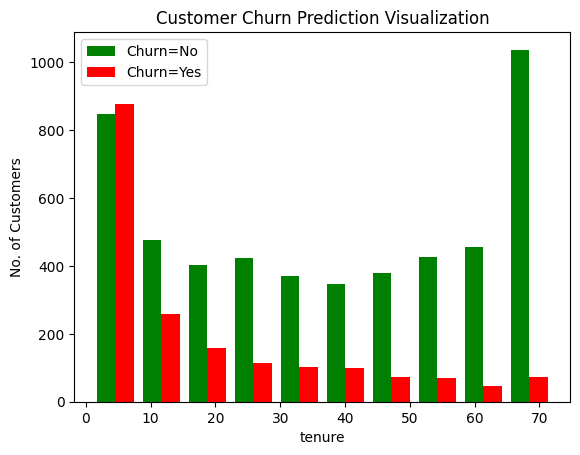

In [15]:
tenure_churn_no = df1[df1.Churn=='No'].tenure
tenure_churn_yes = df1[df1.Churn=='Yes'].tenure

plt.xlabel('tenure')
plt.ylabel('No. of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([tenure_churn_no, tenure_churn_yes], color=['green','red'],label=['Churn=No','Churn=Yes'])
plt.legend()

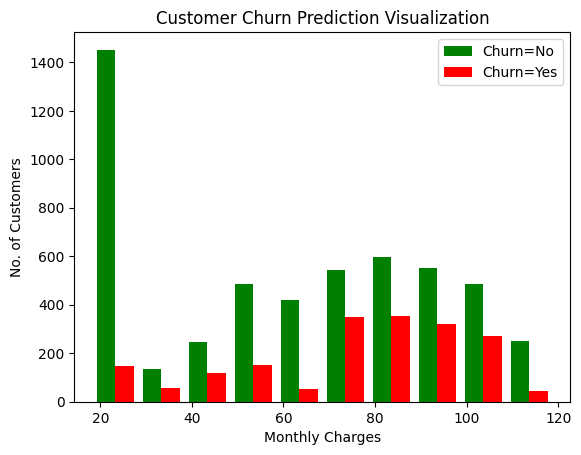

In [16]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges

plt.xlabel('Monthly Charges')
plt.ylabel('No. of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([mc_churn_no, mc_churn_yes], color=['green','red'],label=['Churn=No','Churn=Yes'])
plt.legend()

# Data Cleaning

In [17]:
def print_unique_col_values(df):
    for col in df:
        if df[col].dtypes == 'object':
            print(f'{col} : {df[col].unique()} \n')

In [18]:
print_unique_col_values(df1)

gender : ['Female' 'Male'] 

Partner : ['Yes' 'No'] 

Dependents : ['No' 'Yes'] 

PhoneService : ['No' 'Yes'] 

MultipleLines : ['No phone service' 'No' 'Yes'] 

InternetService : ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity : ['No' 'Yes' 'No internet service'] 

OnlineBackup : ['Yes' 'No' 'No internet service'] 

DeviceProtection : ['No' 'Yes' 'No internet service'] 

TechSupport : ['No' 'Yes' 'No internet service'] 

StreamingTV : ['No' 'Yes' 'No internet service'] 

StreamingMovies : ['No' 'Yes' 'No internet service'] 

Contract : ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling : ['Yes' 'No'] 

PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

Churn : ['No' 'Yes'] 



In [19]:
df1 = df1.replace('No internet service', 'No')
df1 = df1.replace('No phone service', 'No')

In [20]:
print_unique_col_values(df1)

gender : ['Female' 'Male'] 

Partner : ['Yes' 'No'] 

Dependents : ['No' 'Yes'] 

PhoneService : ['No' 'Yes'] 

MultipleLines : ['No' 'Yes'] 

InternetService : ['DSL' 'Fiber optic' 'No'] 

OnlineSecurity : ['No' 'Yes'] 

OnlineBackup : ['Yes' 'No'] 

DeviceProtection : ['No' 'Yes'] 

TechSupport : ['No' 'Yes'] 

StreamingTV : ['No' 'Yes'] 

StreamingMovies : ['No' 'Yes'] 

Contract : ['Month-to-month' 'One year' 'Two year'] 

PaperlessBilling : ['Yes' 'No'] 

PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 

Churn : ['No' 'Yes'] 



In [21]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']

for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

In [22]:
for col in df1:
    print(f'{col} : {df1[col].unique()}')

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService : [0 1]
MultipleLines : [0 1]
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
TechSupport : [0 1]
StreamingTV : [0 1]
StreamingMovies : [0 1]
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : [1 0]
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn : [0 1]


In [23]:
# df1['gender'].replace({'Female':1,'Male':0},inplace=True)
df1['gender'] = df1['gender'].replace({'Female': 1, 'Male': 0})

# df1.loc[:, 'gender'] = df1['gender'].replace({'Female': 1, 'Male': 0})

In [24]:
df1.gender.unique()

array([1, 0])

# One Hot Encoding

In [25]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'], dtype=int)
df2.columns

# for one col -> it created new cols of unique values

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [26]:
df2.sample(4)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2641,1,1,0,0,5,1,0,1,1,0,...,1,0,0,1,0,0,0,1,0,0
822,0,0,0,0,47,1,1,0,1,1,...,0,1,0,0,1,0,0,0,1,0
770,0,0,0,0,11,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1127,1,0,1,1,23,1,0,1,1,1,...,1,0,0,0,1,0,0,0,0,1


In [27]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          int64
InternetService_Fiber optic                  int64
InternetService_No             

# Scaling Data
*  tenure
*  MonthlyCharges
*  TotalCharges

In [28]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [29]:
df2.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6243,1,0,1,1,1.000000,1,1,1,1,1,...,1,0,0,0,0,1,0,1,0,0
3368,1,0,0,0,0.633803,1,1,0,1,1,...,0,1,0,0,1,0,0,0,1,0
352,1,1,0,0,0.084507,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [30]:
for col in df2:
    print(f'{col} : {df2[col].unique()}')

gender : [1 0]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService : [0 1]
MultipleLines : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
Tech

# Train Test Split

In [31]:
X = df2.drop('Churn', axis = 'columns')
y = df2['Churn']

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [33]:
X_train.shape

(5625, 26)

In [34]:
X_test.shape

(1407, 26)

In [35]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,...,0,1,0,1,0,0,0,1,0,0
101,1,0,1,1,0.000000,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
2621,0,0,1,0,0.985915,1,0,0,1,1,...,1,0,0,0,0,1,0,1,0,0
392,1,1,0,0,0.014085,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1327,0,0,1,0,0.816901,1,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
3607,1,0,0,0,0.169014,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
2773,0,0,1,0,0.323944,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1936,1,0,1,0,0.704225,1,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
5387,0,0,0,0,0.042254,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
4331,0,0,0,0,0.985915,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0


In [36]:
len(X_train.columns)

26

# Model Training

In [37]:
import tensorflow as tf
from tensorflow import keras


In [38]:
import os

os.environ['CUDA_HOME'] = '/usr/local/cuda'
os.environ['CUDA_PATH'] = '/usr/local/cuda'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'

In [39]:
model = keras.Sequential([
    keras.layers.Dense(20, input_shape=(26,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer ='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

# adam: 0.8057
# Nadam: 0.8010
# Lion: 0.8100
# RMSprop: 0.127


Epoch 1/100
176/176 [==============================] - 1s 2ms/step - loss: 0.4985 - accuracy: 0.7577
Epoch 2/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.7950
Epoch 3/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4234 - accuracy: 0.7995
Epoch 4/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8030
Epoch 5/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4140 - accuracy: 0.8034
Epoch 6/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4121 - accuracy: 0.8057
Epoch 7/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4109 - accuracy: 0.8071
Epoch 8/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4090 - accuracy: 0.8098
Epoch 9/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4090 - accuracy: 0.8098
Epoch 10/100
176/176 [==============================] - 0s 2ms/step - loss: 0.4065 - accura

In [40]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 1ms/step - loss: 0.4629 - accuracy: 0.7875


[0.4628985524177551, 0.7874911427497864]

In [41]:
yp = model.predict(X_test)
yp[:5]

44/44 [==============================] - 0s 1ms/step


array([[0.12630746],
       [0.5476593 ],
       [0.0212666 ],
       [0.728293  ],
       [0.48260903]], dtype=float32)

In [42]:
y_test[:5]

2660    0
744     0
5579    1
64      1
3287    1
Name: Churn, dtype: int64

In [43]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [44]:
y_pred[:10]

[0, 1, 0, 1, 0, 1, 0, 0, 0, 0]

In [45]:
y_test[:10]

2660    0
744     0
5579    1
64      1
3287    1
816     1
2670    0
5920    0
1023    0
6087    0
Name: Churn, dtype: int64

In [46]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       999
           1       0.67      0.53      0.59       408

    accuracy                           0.79      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



Text(95.72222222222221, 0.5, 'Thruth')

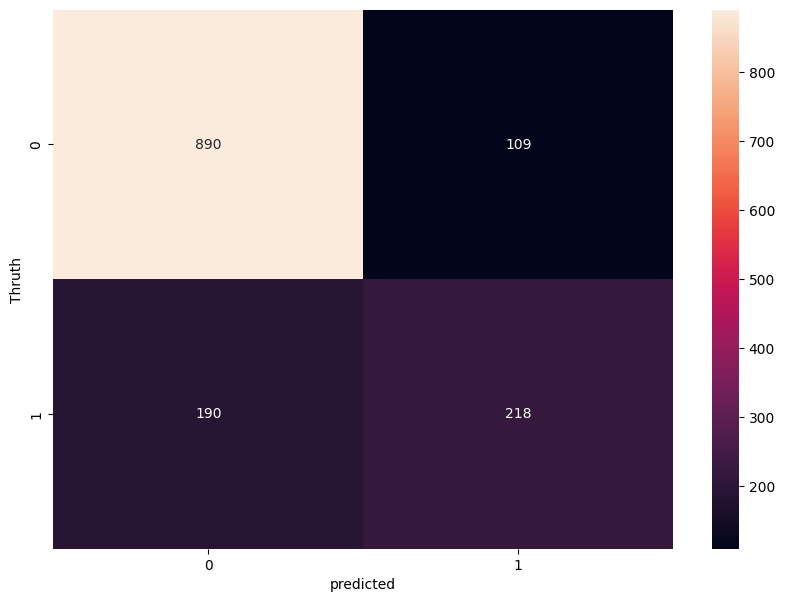

In [47]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Thruth')

In [48]:
y_test.shape

(1407,)

**Accuracy**

In [54]:
round((890+218)/(890+218+109+190),2)

0.79

**Precision for 0 class. i.e. Precision for customers who did not churn**

In [55]:
round(890/(890+190),2)

0.82

**Precision for 1 class. i.e. Precision for customers who actually churned**

In [56]:
round(218/(218+109),2)

0.67

**Recall for 0 class**

In [57]:
round(890/(890+109),2)


0.89

In [58]:
round(290/(290+190),2)

0.6